In [82]:
# =========================================================
# Options Income Strategy — Full Profitability & Capital Analysis
# Integrated with your download snippet (Google Sheets → Excel via curl)
# - Assignment detection: ONLY the word "assigned" in Comment
# - Side inferred from Type; handles "Put/Call" and "Call/Put" (strike like "A/B")
# - Capital: cash-secured short puts + cash tied in assigned shares (per-lot FIFO segments)
# - Realized P&L (options + stock) by year; annualizes current YTD only
# - Unrealized P&L via Yahoo Finance (yfinance); optionally folded into current year
# - Exports Excel report: options_profitability_report.xlsx
# =========================================================

# ---- Your imports & download code (kept exactly, with a tiny print) ----
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, pathlib, subprocess, shlex, os, re, warnings, io, datetime as dt
warnings.filterwarnings('ignore')

SHEET_ID = "19LhrZai3cbJ1GbPE1iTquYHUeXfpIxXFX1amF5eWi_g"   # <-- paste only the ID string
FILE = 'IBKR_Portfolio_sheets.xlsx'

url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=xlsx'
subprocess.run(shlex.split(f'curl -L -o {FILE} {url}'), check=True)

# --------------------------
# Config
# --------------------------
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
from collections import defaultdict
import math

EXCEL_PATH = FILE
SHEETS = ["Options 2024", "Options 2025"]
CONTRACT_MULTIPLIER = 100
AS_OF_DATE: Optional[str] = None   # e.g., "2025-08-16"; None → today
INCLUDE_UNREALIZED_IN_CURRENT_YEAR = True
EXPORT_REPORT_PATH = "options_profitability_report.xlsx"

Downloaded: /content/IBKR_Portfolio_sheets.xlsx


In [ ]:

# --- Helpers for pretty tables ---
def _format_styler(df, currency_cols=None, pct_cols=None):
    currency_cols = set(currency_cols or [])
    pct_cols = set(pct_cols or [])
    fmt_map = {}
    for c in df.columns:
        if c in currency_cols:
            fmt_map[c] = lambda v: "" if pd.isna(v) else f"{v:,.0f}"
        elif c in pct_cols:
            fmt_map[c] = lambda v: "" if pd.isna(v) else f"{v:.1%}"
    sty = df.style.format(fmt_map).set_properties(**{"text-align": "right"})                    .set_table_styles([{"selector":"th","props":"text-align:left;padding-right:8px;"},
                                      {"selector":"td","props":"padding:4px 8px;"}])
    try:
        sty = sty.hide(axis="index")
    except Exception:
        sty = sty.hide_index()
    return sty

def _safe_cols(df, cols):
    return [c for c in cols if c in df.columns]

In [83]:
# --------------------------
# Load options (keep raw Type, including Put/Call and Call/Put)
# --------------------------
def load_options() -> pd.DataFrame:
    frames = []
    for sh in SHEETS:
        raw = pd.read_excel(EXCEL_PATH, sheet_name=sh, header=1)
        df = raw.rename(columns={
            "Trans date": "trans_date",
            "Tiker": "ticker",
            "Type": "type",
            "Action": "action",
            "Expiration": "expiration",
            "Strike": "strike",
            "Qty": "qty",
            "Amount": "amount",
            "Comission": "commission",
            "Total P&L": "total_pnl",
            "Comment": "comment",
        })
        for d in ["trans_date","expiration"]:
            df[d] = pd.to_datetime(df[d], errors="coerce").dt.tz_localize(None)
        for n in ["strike","qty","amount","commission","total_pnl"]:
            df[n] = pd.to_numeric(df[n], errors="coerce")
        df["ticker"]  = df["ticker"].astype(str).str.upper().str.strip()
        df["action"]  = df["action"].astype(str).str.title().str.strip()
        df["type"]    = df["type"].astype(str).str.title().str.strip()
        df["comment"] = df["comment"].astype(str)
        df["source_sheet"] = sh
        frames.append(df)
    df_all = pd.concat(frames, ignore_index=True)
    df_all = df_all[df_all["action"].isin(["Sell","Buy"])]
    return df_all

df_opts = load_options()

In [84]:
# --------------------------
# Lots (short-leg tracking) & assignment detection
# --------------------------
@dataclass
class OptionLot:
    ticker: str
    otype: str   # "Put" or "Call" (the SHORT leg we track)
    strike: float
    qty: float   # contracts
    open_date: pd.Timestamp
    expiration: pd.Timestamp
    premium_net: float  # uses row "Total P&L"
    comment: str
    assigned: bool
    close_date: pd.Timestamp
    close_reason: str   # "expiration" | "closed_early" | "assigned_expiration"

def parse_strike_pair(s: str) -> Tuple[float,float]:
    try:
        a, b = str(s).split("/")
        return float(a), float(b)
    except Exception:
        return math.nan, math.nan

def infer_mixed_short_leg(row: pd.Series) -> Tuple[str, float]:
    """
    For Type 'Put/Call' or 'Call/Put', infer the SHORT leg and its strike.

    Heuristics:
      - If Comment mentions 'short call' or 'long put' -> short call.
      - Else default to short put (typical risk reversal: long call + short put).

    Strikes by order in Type:
      'Put/Call': first = put, second = call
      'Call/Put': first = call, second = put
    """
    t_low = str(row.get("type","")).lower()
    c_low = str(row.get("comment","")).lower()
    a, b = parse_strike_pair(row.get("strike",""))
    put_strike = call_strike = math.nan
    if "put/call" in t_low:
        put_strike, call_strike = a, b
    elif "call/put" in t_low:
        call_strike, put_strike = a, b

    if ("short call" in c_low) or ("long put" in c_low):
        return "Call", call_strike
    else:
        return "Put", put_strike

def build_short_lots_from_rows(df: pd.DataFrame) -> List[OptionLot]:
    lots: List[OptionLot] = []
    rows = df.sort_values(["ticker","trans_date"]).reset_index(drop=True)
    for r in rows.itertuples(index=False):
        t_raw = str(r.type).strip()
        action = r.action
        cmt = r.comment if pd.notna(r.comment) else ""
        # ONLY the word 'assigned' marks assignment (per your rule)
        assigned = ("assigned" in cmt.lower())

        if t_raw in ("Put","Call"):
            if action != "Sell":  # only short single-leg
                continue
            lot = OptionLot(
                ticker=r.ticker,
                otype=t_raw,
                strike=float(r.strike) if pd.notna(r.strike) else math.nan,
                qty=float(r.qty) if pd.notna(r.qty) else 0.0,
                open_date=r.trans_date,
                expiration=r.expiration,
                premium_net=float(r.total_pnl) if pd.notna(r.total_pnl) else 0.0,
                comment=cmt,
                assigned=assigned,
                close_date=r.expiration,
                close_reason="assigned_expiration" if assigned else "expiration",
            )
            lots.append(lot)

        elif ("put/call" in t_raw.lower()) or ("call/put" in t_raw.lower()):
            short_leg, short_strike = infer_mixed_short_leg(r._asdict())
            if pd.isna(short_strike):
                continue
            lot = OptionLot(
                ticker=r.ticker,
                otype=short_leg,
                strike=float(short_strike),
                qty=float(r.qty) if pd.notna(r.qty) else 0.0,
                open_date=r.trans_date,
                expiration=r.expiration,
                premium_net=float(r.total_pnl) if pd.notna(r.total_pnl) else 0.0,
                comment=cmt,
                assigned=assigned,  # 'assigned' applies to the short leg
                close_date=r.expiration,
                close_reason="assigned_expiration" if assigned else "expiration",
            )
            lots.append(lot)
        else:
            continue
    return lots

def apply_buy_to_close_closeouts(lots: List[OptionLot], df: pd.DataFrame) -> None:
    """Match Buy rows to earliest open short (ticker, type, strike, expiration) and close earlier."""
    key_to_indices: Dict[Tuple, List[int]] = defaultdict(list)
    for i, lot in enumerate(lots):
        exp = pd.to_datetime(lot.expiration)
        exp = exp.normalize() if pd.notna(exp) else pd.NaT
        key = (lot.ticker, lot.otype, lot.strike, exp)
        key_to_indices[key].append(i)

    buys = df[(df["action"]=="Buy") & (df["type"].isin(["Put","Call"]))].copy()
    buys = buys.sort_values("trans_date")
    for _, b in buys.iterrows():
        exp = pd.to_datetime(b["expiration"])
        exp = exp.normalize() if pd.notna(exp) else pd.NaT
        key = (str(b["ticker"]).upper().strip(),
               str(b["type"]),
               float(b["strike"]),
               exp)
        indices = key_to_indices.get(key, [])
        if not indices:
            continue
        buy_date = b["trans_date"]
        for idx in indices:
            lot = lots[idx]
            if lot.open_date <= buy_date < lot.close_date:
                lot.close_date = buy_date
                lot.close_reason = "closed_early"
                break

lots = build_short_lots_from_rows(df_opts)
apply_buy_to_close_closeouts(lots, df_opts)

In [85]:
# --------------------------
# Stock transactions from assigned lots
# --------------------------
@dataclass
class StockTxn:
    date: pd.Timestamp
    ticker: str
    side: str   # "BUY" or "SELL"
    shares: int
    price: float
    source: str # "Assigned"

def stock_txns_from_assigned_lots(lots: List[OptionLot]) -> List[StockTxn]:
    txns: List[StockTxn] = []
    for lot in lots:
        if not lot.assigned:
            continue
        shares = int(round(lot.qty * CONTRACT_MULTIPLIER))
        if shares == 0:
            continue
        if lot.otype == "Put":
            txns.append(StockTxn(lot.close_date.normalize(), lot.ticker, "BUY",  shares, lot.strike, "Assigned"))
        else:  # Call
            txns.append(StockTxn(lot.close_date.normalize(), lot.ticker, "SELL", shares, lot.strike, "Assigned"))
    return txns

stock_txns = stock_txns_from_assigned_lots(lots)

In [86]:
# --------------------------
# Realized P&L (FIFO) and Ending Inventory
# --------------------------
@dataclass
class RealizedSale:
    date: pd.Timestamp
    ticker: str
    shares: int
    proceeds: float
    cost: float
    pnl: float

@dataclass
class OpenLot:
    ticker: str
    buy_date: pd.Timestamp
    shares_remaining: int
    cost_per_share: float

def compute_stock_realized_and_inventory(txns: List[StockTxn]):
    by_ticker: Dict[str, List[OpenLot]] = defaultdict(list)
    realized: List[RealizedSale] = []
    for t in sorted(txns, key=lambda x: (x.date, x.ticker)):
        if t.side == "BUY":
            by_ticker[t.ticker].append(OpenLot(t.ticker, t.date, t.shares, t.price))
        else:  # SELL
            qty_to_sell = t.shares
            cost_accum = 0.0
            while qty_to_sell > 0 and by_ticker[t.ticker]:
                lot = by_ticker[t.ticker][0]
                take = min(qty_to_sell, lot.shares_remaining)
                cost_accum += take * lot.cost_per_share
                lot.shares_remaining -= take
                qty_to_sell -= take
                if lot.shares_remaining == 0:
                    by_ticker[t.ticker].pop(0)
            proceeds = t.shares * t.price
            cost = cost_accum + (qty_to_sell * t.price if qty_to_sell>0 else 0.0)
            realized.append(RealizedSale(t.date, t.ticker, t.shares, proceeds, cost, proceeds - cost))
    inventory: List[OpenLot] = []
    for tk, lots_list in by_ticker.items():
        for lot in lots_list:
            if lot.shares_remaining > 0:
                inventory.append(lot)
    return realized, inventory

realized_sales, ending_inventory = compute_stock_realized_and_inventory(stock_txns)

In [87]:
# --------------------------
# Holding segments per BUY lot (accurate capital timeline for shares)
# --------------------------
@dataclass
class HoldSeg:
    ticker: str
    start: pd.Timestamp
    end: pd.Timestamp
    shares: int
    cost_per_share: float

def build_holding_segments(txns: List[StockTxn], as_of: pd.Timestamp) -> List[HoldSeg]:
    """Build per-lot holding segments using FIFO. Each BUY portion sold generates a segment [buy, sell). Unsold → [buy, as_of)."""
    open_buys: Dict[str, List[OpenLot]] = defaultdict(list)
    segs: List[HoldSeg] = []
    for t in sorted(txns, key=lambda x: (x.date, x.ticker)):
        if t.side == "BUY":
            open_buys[t.ticker].append(OpenLot(t.ticker, t.date, t.shares, t.price))
        else:  # SELL
            qty = t.shares
            while qty > 0 and open_buys[t.ticker]:
                lot = open_buys[t.ticker][0]
                used = min(qty, lot.shares_remaining)
                segs.append(HoldSeg(t.ticker, lot.buy_date.normalize(), min(t.date.normalize(), as_of), int(used), lot.cost_per_share))
                lot.shares_remaining -= used
                qty -= used
                if lot.shares_remaining == 0:
                    open_buys[t.ticker].pop(0)
    # Remaining open shares
    for tk, lots_list in open_buys.items():
        for lot in lots_list:
            if lot.shares_remaining > 0:
                segs.append(HoldSeg(tk, lot.buy_date.normalize(), as_of, int(lot.shares_remaining), lot.cost_per_share))
    return segs

In [88]:
# --------------------------
# Capital timeline (daily)
# --------------------------
def get_as_of_date(df_opts: pd.DataFrame) -> pd.Timestamp:
    return pd.to_datetime(AS_OF_DATE).normalize() if AS_OF_DATE else pd.Timestamp.today().normalize()

as_of_date = get_as_of_date(df_opts)

def daterange_days(start: pd.Timestamp, end: pd.Timestamp) -> pd.DatetimeIndex:
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    if pd.isna(start) or pd.isna(end):
        return pd.DatetimeIndex([])
    start = start.normalize()
    end = end.normalize()
    if end <= start:
        end = start + pd.Timedelta(days=1)
    # inclusive start, exclusive end
    return pd.date_range(start, end, freq="D", inclusive="left")

def build_capital_timeline(lots: List[OptionLot], txns: List[StockTxn], as_of: pd.Timestamp) -> pd.DataFrame:
    rows = []
    # Short puts reserve
    for lot in lots:
        if lot.otype == "Put":
            open_d = lot.open_date
            close_d = pd.to_datetime(lot.close_date)
            if pd.isna(close_d):
                close_d = as_of
            else:
                close_d = min(close_d, as_of)
            reserve = lot.strike * CONTRACT_MULTIPLIER * int(round(lot.qty))
            for d in daterange_days(open_d, close_d):
                rows.append((d, "puts_reserve", reserve))
    # Shares invested per holding segment
    segs = build_holding_segments(txns, as_of)
    for seg in segs:
        invested = seg.shares * seg.cost_per_share
        for d in daterange_days(seg.start, seg.end):
            rows.append((d, "shares_invested", invested))
    cap = pd.DataFrame(rows, columns=["date","component","amount"])
    if cap.empty:
        idx = pd.date_range(df_opts["trans_date"].min().normalize(), as_of, freq="D")
        cap = pd.DataFrame({"date": idx, "component": ["puts_reserve"]*len(idx), "amount": [0.0]*len(idx)})
    daily = cap.groupby(["date","component"])["amount"].sum().unstack(fill_value=0.0)
    daily["total"] = daily.sum(axis=1)
    return daily

capital_daily = build_capital_timeline(lots, stock_txns, as_of_date)

In [ ]:

# --------------------------
# Monthly option cycles (standard expiration) & returns
# --------------------------
from pandas.tseries.offsets import WeekOfMonth, MonthBegin


def _third_friday(dt):
    dt = pd.Timestamp(dt)
    return dt.replace(day=1) + WeekOfMonth(week=2, weekday=4)


def _cycle_end(dt):
    dt = pd.Timestamp(dt)
    exp = _third_friday(dt)
    if dt > exp:
        exp = _third_friday(dt + MonthBegin(1))
    return exp


def build_monthly_cycles(df_opts, realized_sales, capital_daily):
    def cyc(d):
        return _cycle_end(d)
    opts = df_opts.copy()
    opts['cycle'] = opts['trans_date'].apply(cyc)
    opts_cycle = opts.groupby('cycle')['total_pnl'].sum().rename('options_pnl_m')
    if realized_sales:
        rs_df = pd.DataFrame({'date':[r.date for r in realized_sales], 'pnl':[r.pnl for r in realized_sales]})
        rs_df['cycle'] = rs_df['date'].apply(cyc)
        stock_cycle = rs_df.groupby('cycle')['pnl'].sum().rename('stock_realized_pnl_m')
    else:
        stock_cycle = pd.Series(dtype=float, name='stock_realized_pnl_m')
    combined = opts_cycle.add(stock_cycle, fill_value=0.0).rename('combined_realized_m')
    cap = capital_daily.copy()
    cap['cycle'] = cap.index.to_series().apply(cyc)
    avg_cap = cap.groupby('cycle')['total'].mean().rename('avg_capital_m')
    monthly = pd.concat([opts_cycle, stock_cycle, combined, avg_cap], axis=1).fillna(0.0)
    monthly['return_m'] = np.where(monthly['avg_capital_m'] > 0,
                                   monthly['combined_realized_m'] / monthly['avg_capital_m'],
                                   np.nan)
    return monthly


monthly = build_monthly_cycles(df_opts, realized_sales, capital_daily)


def twr_annualized_by_year(ret_series):
    grouped = ret_series.groupby(ret_series.index.year)
    return grouped.apply(lambda r: (1 + r).prod() ** (12/len(r)) - 1)


twr_annualized = twr_annualized_by_year(monthly['return_m'].dropna())

In [89]:
# --------------------------
# Yearly P&L & returns (realized)
# --------------------------
def options_pnl_by_year(df: pd.DataFrame) -> pd.DataFrame:
    tmp = df.copy()
    tmp["year"] = tmp["trans_date"].dt.year
    return tmp.groupby("year")["total_pnl"].sum().rename("options_pnl").reset_index()

def realized_stock_pnl_by_year(realized_sales: List[RealizedSale]) -> pd.DataFrame:
    if not realized_sales:
        return pd.DataFrame(columns=["year","stock_realized_pnl"])
    df = pd.DataFrame([{"date": r.date, "ticker": r.ticker, "shares": r.shares, "pnl": r.pnl} for r in realized_sales])
    df["year"] = df["date"].dt.year
    return df.groupby("year")["pnl"].sum().rename("stock_realized_pnl").reset_index()

def capital_stats_by_year(capital_daily: pd.DataFrame) -> pd.DataFrame:
    df = capital_daily.reset_index()
    df["year"] = df["date"].dt.year
    return df.groupby("year").agg(avg_capital=("total","mean"), peak_capital=("total","max")).reset_index()

def combine_yearly(options_df, realized_df, capital_df, as_of):
    years = sorted(set(capital_df["year"]).union(options_df["year"]).union(realized_df["year"]))
    out = pd.DataFrame({"year": years})
    out = out.merge(options_df, on="year", how="left") \
             .merge(realized_df, on="year", how="left") \
             .merge(capital_df, on="year", how="left")
    out = out.fillna(0.0)
    out["combined_realized"] = out["options_pnl"] + out["stock_realized_pnl"]
    # days elapsed per year from capital timeline
    elapsed_days = (
        capital_daily.reset_index()
        .assign(year=lambda d: d["date"].dt.year)
        .groupby("year")["date"].nunique()
        .rename("days_elapsed").reset_index()
    )
    out = out.merge(elapsed_days, on="year", how="left").fillna({"days_elapsed": 365})
    out["return_on_avg"]  = out["combined_realized"] / out["avg_capital"].replace({0: pd.NA})
    out["return_on_peak"] = out["combined_realized"] / out["peak_capital"].replace({0: pd.NA})
    current_year = as_of.year
    mask_curr = (out["year"] == current_year) & (out["days_elapsed"] < 365)
    factor = 365.0 / out["days_elapsed"]
    out["annualized_return_on_avg"] = out["return_on_avg"]
    out.loc[mask_curr, "annualized_return_on_avg"] = out.loc[mask_curr, "return_on_avg"] * factor[mask_curr]
    out["annualized_return_on_peak"] = out["return_on_peak"]
    out.loc[mask_curr, "annualized_return_on_peak"] = out.loc[mask_curr, "return_on_peak"] * factor[mask_curr]
    return out

opts_year  = options_pnl_by_year(df_opts)
stock_year = realized_stock_pnl_by_year(realized_sales)
cap_year   = capital_stats_by_year(capital_daily)
yearly     = combine_yearly(opts_year, stock_year, cap_year, as_of_date)
yearly = yearly.merge(twr_annualized.rename('annualized_return_twr'), left_on='year', right_index=True, how='left')

In [90]:
# --------------------------
# Per-ticker realized P&L by year
# --------------------------
def per_ticker_yearly(df_opts: pd.DataFrame, realized_sales: List[RealizedSale]) -> pd.DataFrame:
    o = df_opts.copy()
    o["year"] = o["trans_date"].dt.year
    o_t = o.groupby(["year","ticker"])["total_pnl"].sum().rename("options_pnl").reset_index()
    if realized_sales:
        s = pd.DataFrame([{"date": r.date, "ticker": r.ticker, "pnl": r.pnl} for r in realized_sales])
        s["year"] = s["date"].dt.year
        s_t = s.groupby(["year","ticker"])["pnl"].sum().rename("stock_realized_pnl").reset_index()
    else:
        s_t = pd.DataFrame(columns=["year","ticker","stock_realized_pnl"])
    out = o_t.merge(s_t, on=["year","ticker"], how="outer").fillna(0.0)
    out["combined_realized"] = out["options_pnl"] + out["stock_realized_pnl"]
    return out.sort_values(["year","combined_realized"], ascending=[True, False])

per_ticker = per_ticker_yearly(df_opts, realized_sales)

In [91]:
# --------------------------
# Yahoo Finance prices (for unrealized P&L)
# --------------------------
def _ensure_yfinance():
    try:
        import yfinance as yf  # noqa
        return yf
    except Exception:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "yfinance"])
            import yfinance as yf  # noqa
            return yf
        except Exception as e:
            raise RuntimeError("Please install yfinance: pip install yfinance") from e

def fetch_current_prices_yf(tickers) -> Dict[str, float]:
    yf = _ensure_yfinance()
    tickers = sorted({str(t).upper().strip() for t in tickers if isinstance(t, str) and t.strip()})
    prices: Dict[str,float] = {}
    if not tickers:
        return prices

    # Batch attempt
    try:
        data = yf.download(
            tickers=tickers, period="5d", interval="1d",
            auto_adjust=False, progress=False, group_by="ticker", threads=True
        )
        if isinstance(data.columns, pd.MultiIndex):
            for t in tickers:
                series = None
                for col in ("Adj Close", "Close"):
                    try:
                        series = data[(t, col)].dropna()
                        if not series.empty: break
                    except KeyError:
                        continue
                if series is not None and not series.empty:
                    prices[t] = float(series.iloc[-1])
        else:
            # single ticker shape
            series = data["Adj Close"].dropna() if "Adj Close" in data else data["Close"].dropna()
            if not series.empty and len(tickers) == 1:
                prices[tickers[0]] = float(series.iloc[-1])
    except Exception:
        pass

    # Per-ticker fallback
    missing = [t for t in tickers if t not in prices]
    for t in missing:
        try:
            tk = yf.Ticker(t)
            hist = tk.history(period="5d", interval="1d")
            if not hist.empty:
                prices[t] = float(hist["Close"].iloc[-1])
                continue
            try:
                p = getattr(tk.fast_info, "last_price", None)
                if p:
                    prices[t] = float(p)
            except Exception:
                pass
        except Exception:
            pass
    return prices

def unrealized_as_of(inventory: List[OpenLot], prices: Dict[str, float]) -> Tuple[pd.DataFrame, float]:
    rows = []
    total_unreal = 0.0
    for lot in inventory:
        px = prices.get(lot.ticker)
        if px is None or pd.isna(px) or px <= 0:
            continue
        unreal = (px - lot.cost_per_share) * lot.shares_remaining
        rows.append({
            "ticker": lot.ticker,
            "buy_date": lot.buy_date.date(),
            "shares": lot.shares_remaining,
            "cost_per_share": lot.cost_per_share,
            "current_price": px,
            "unrealized_pnl": unreal,
        })
        total_unreal += unreal
    return pd.DataFrame(rows), total_unreal

tickers_to_price = sorted({lot.ticker for lot in ending_inventory})
try:
    live_prices = fetch_current_prices_yf(tickers_to_price)
except Exception as e:
    live_prices = {}

inv_df, total_unreal = unrealized_as_of(ending_inventory, live_prices)

In [92]:
# Optionally include unrealized in current-year metrics
yearly_with_unreal = yearly.copy()
yearly_with_unreal["combined_incl_unreal"] = yearly_with_unreal["combined_realized"]
yearly_with_unreal["return_on_avg_incl_unreal"]  = yearly_with_unreal["return_on_avg"]
yearly_with_unreal["return_on_peak_incl_unreal"] = yearly_with_unreal["return_on_peak"]
yearly_with_unreal["annualized_return_on_avg_incl_unreal"]  = yearly_with_unreal["annualized_return_on_avg"]
yearly_with_unreal["annualized_return_on_peak_incl_unreal"] = yearly_with_unreal["annualized_return_on_peak"]

if INCLUDE_UNREALIZED_IN_CURRENT_YEAR and total_unreal != 0:
    mask_curr = yearly_with_unreal["year"].eq(as_of_date.year)
    if mask_curr.any():
        yearly_with_unreal.loc[mask_curr, "combined_incl_unreal"] = (
            yearly_with_unreal.loc[mask_curr, "combined_realized"] + total_unreal
        )
        yearly_with_unreal.loc[mask_curr, "return_on_avg_incl_unreal"] = (
            yearly_with_unreal.loc[mask_curr, "combined_incl_unreal"] / yearly_with_unreal.loc[mask_curr, "avg_capital"].replace({0: pd.NA})
        )
        yearly_with_unreal.loc[mask_curr, "return_on_peak_incl_unreal"] = (
            yearly_with_unreal.loc[mask_curr, "combined_incl_unreal"] / yearly_with_unreal.loc[mask_curr, "peak_capital"].replace({0: pd.NA})
        )
        mask = mask_curr & yearly_with_unreal["days_elapsed"].lt(365)
        factor = 365.0 / yearly_with_unreal.loc[mask, "days_elapsed"]
        yearly_with_unreal.loc[mask, "annualized_return_on_avg_incl_unreal"] = yearly_with_unreal.loc[mask, "return_on_avg_incl_unreal"] * factor
        yearly_with_unreal.loc[mask, "annualized_return_on_peak_incl_unreal"] = yearly_with_unreal.loc[mask, "return_on_peak_incl_unreal"] * factor

year,options_pnl,stock_realized_pnl,combined_realized,avg_capital,peak_capital,return_on_avg,return_on_peak,annualized_return_on_avg,annualized_return_on_peak
2024,"11,949","-3,150","8,799","61,234","125,250",14.4%,7.0%,14.4%,7.0%
2025,"12,715",0,"12,715","108,532","152,600",11.7%,8.3%,18.8%,13.4%



Current year (incl. unrealized):


year,avg_capital,peak_capital,combined (incl. unrealized),RoAvg (incl. unrl),RoPeak (incl. unrl),Ann RoAvg (incl. unrl),Ann RoPeak (incl. unrl)
2025,"108,532","152,600","27,947",25.7%,18.3%,41.4%,29.4%


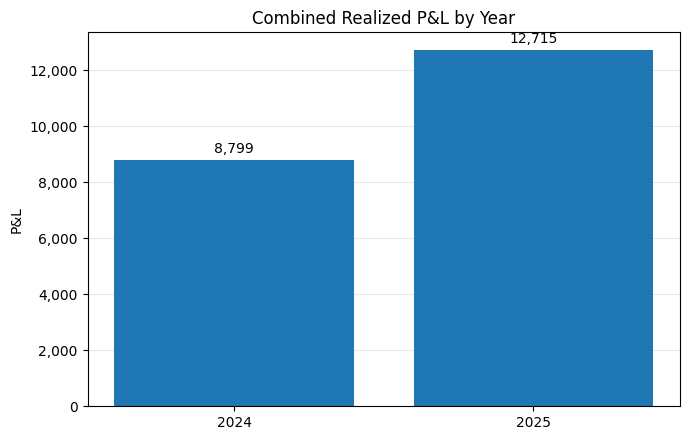

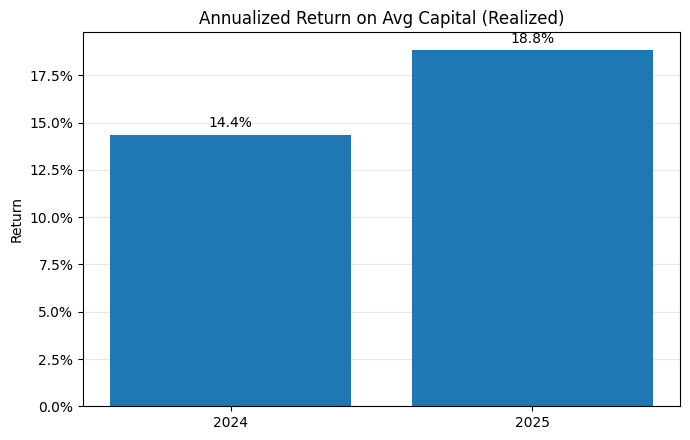

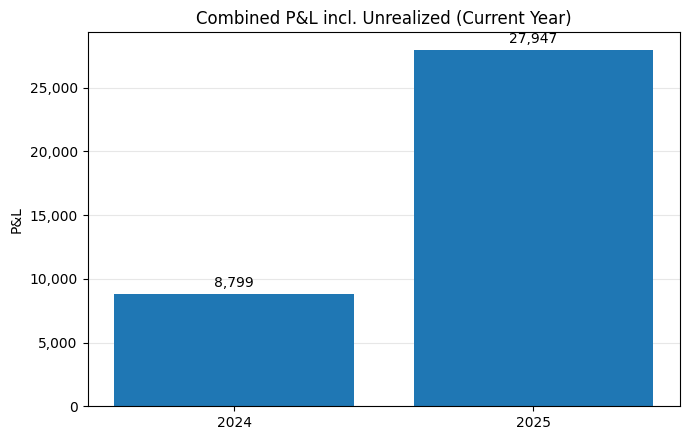

In [93]:
# ============================
# Clean display & visualization (drop-in replacement)
# Requires: yearly, yearly_with_unreal, per_ticker, as_of_date
# ============================
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# --- Yearly summary (compact & formatted) ---
summary_cols = [
    "year", "options_pnl", "stock_realized_pnl", "combined_realized",
    "avg_capital", "peak_capital",
    "return_on_avg", "return_on_peak",
    "annualized_return_on_avg", "annualized_return_on_peak",
    "annualized_return_twr"
]
summary = yearly[_safe_cols(yearly, summary_cols)].copy().sort_values("year")

currency_cols = _safe_cols(summary, ["options_pnl","stock_realized_pnl","combined_realized","avg_capital","peak_capital"])
pct_cols      = _safe_cols(summary, ["return_on_avg","return_on_peak","annualized_return_on_avg","annualized_return_on_peak","annualized_return_twr"])


# --- Current year incl. unrealized (short, only if available) ---
if "combined_incl_unreal" in yearly_with_unreal.columns:
    curr = yearly_with_unreal[yearly_with_unreal["year"].eq(as_of_date.year)].copy()
    if not curr.empty:
        cols_incl = _safe_cols(curr, [
            "year", "avg_capital", "peak_capital",
            "combined_incl_unreal",
            "return_on_avg_incl_unreal", "return_on_peak_incl_unreal",
            "annualized_return_on_avg_incl_unreal", "annualized_return_on_peak_incl_unreal"
        ])
        incl_tbl = curr[cols_incl].rename(columns={
            "combined_incl_unreal":"combined (incl. unrealized)",
            "return_on_avg_incl_unreal":"RoAvg (incl. unrl)",
            "return_on_peak_incl_unreal":"RoPeak (incl. unrl)",
            "annualized_return_on_avg_incl_unreal":"Ann RoAvg (incl. unrl)",
            "annualized_return_on_peak_incl_unreal":"Ann RoPeak (incl. unrl)",
        })
        currency_incl = _safe_cols(incl_tbl, ["avg_capital","peak_capital","combined (incl. unrealized)"])
        pct_incl = _safe_cols(incl_tbl, ["RoAvg (incl. unrl)","RoPeak (incl. unrl)","Ann RoAvg (incl. unrl)","Ann RoPeak (incl. unrl)"])

# ------------------
# Charts: 2024 vs 2025
# ------------------
yr = yearly.set_index("year").sort_index()
years_order = [y for y in [2024, 2025] if y in yr.index] or list(yr.index)

# 1) Combined realized P&L by year
if all(c in yr.columns for c in ["combined_realized"]):
    vals = [float(yr.loc[y, "combined_realized"]) for y in years_order]
    fig, ax = plt.subplots(figsize=(7, 4.5))
    bars = ax.bar([str(y) for y in years_order], vals)
    ax.set_title("Combined Realized P&L by Year")
    ax.set_ylabel("P&L")
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    ax.grid(axis="y", alpha=0.3)
    ax.set_axisbelow(True)
    # Proper bar labels: pass the bar container, not a list
    labels = [f"{v:,.0f}" for v in vals]
    ax.bar_label(bars, labels=labels, padding=3)
    plt.tight_layout()
    plt.show()


# 2) Annualized return on average capital (realized) — 2024 vs 2025
if "annualized_return_on_avg" in yr.columns:
    ret_vals = [float(yr.loc[y, "annualized_return_on_avg"]) for y in years_order]
    fig, ax = plt.subplots(figsize=(7, 4.5))
    bars = ax.bar([str(y) for y in years_order], ret_vals)
    ax.set_title("Annualized Return on Avg Capital (Realized)")
    ax.set_ylabel("Return")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.grid(axis="y", alpha=0.3)
    ax.set_axisbelow(True)
    labels = [f"{v:.1%}" for v in ret_vals]
    ax.bar_label(bars, labels=labels, padding=3)
    plt.tight_layout()
    plt.show()


# 3) (Optional) Combined incl. unrealized for current year vs prior
if "combined_incl_unreal" in yearly_with_unreal.columns:
    yrs2 = yearly_with_unreal.set_index("year")
    if all(y in yrs2.index for y in years_order):
        vals_incl = []
        for y in years_order:
            if y == as_of_date.year:
                vals_incl.append(float(yrs2.loc[y, "combined_incl_unreal"]))
            else:
                vals_incl.append(float(yr.loc[y, "combined_realized"]))
        fig, ax = plt.subplots(figsize=(7, 4.5))
        bars = ax.bar([str(y) for y in years_order], vals_incl)
        ax.set_title("Combined P&L incl. Unrealized (Current Year)")
        ax.set_ylabel("P&L")
        ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
        ax.grid(axis="y", alpha=0.3)
        ax.set_axisbelow(True)
        labels = [f"{v:,.0f}" for v in vals_incl]
        ax.bar_label(bars, labels=labels, padding=3)
        plt.tight_layout()
        plt.show()

Risk metrics (monthly):


Months Used,Sortino benchmark,Sortino (annualized),Max Drawdown % (return curve),Max Drawdown $ (cum realized),DD% Peak,DD% Trough,DD% Recovery
20,USD 3M T-Bill (4.11%),3.330000,-5.7%,"-2,950",2024-11-30,2024-12-31,2025-03-31


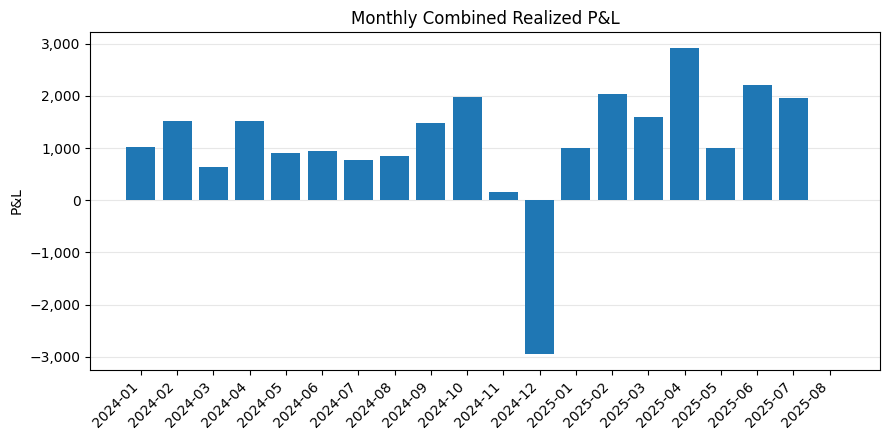

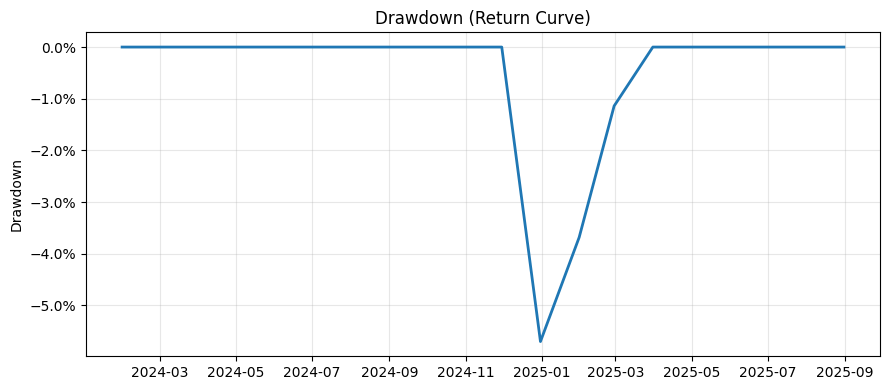

In [94]:
# ============================
# Risk metrics: Sortino & Max Drawdown (monthly) — CLEAN
# Requires: monthly, as_of_date
# ============================
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

ret = monthly["return_m"].dropna()

# --- USD risk-free benchmark (13-week T-bill) for Sortino ---
def _get_usd_risk_free_annual(default=0.05):
    try:
        try:
            yf = _ensure_yfinance()
        except NameError:
            import yfinance as yf  # type: ignore
        hist = yf.Ticker("^IRX").history(period="10d", interval="1d")
        if not hist.empty:
            return float(hist["Close"].dropna().iloc[-1]) / 100.0
    except Exception as e:
    return float(default)

BENCHMARK = "rf"
RISK_FREE_ANNUAL = _get_usd_risk_free_annual(default=0.05)
MAR_ANNUAL = 0.00

bm_annual = RISK_FREE_ANNUAL if BENCHMARK == "rf" else MAR_ANNUAL
bm_m = (1.0 + bm_annual)**(1/12) - 1.0

excess = ret - bm_m

downside = np.minimum(excess, 0.0)
downside_dev_m = np.sqrt(np.mean(np.square(downside))) if len(downside) > 0 else np.nan
mean_excess_m  = np.mean(excess) if len(excess) > 0 else np.nan
sortino_ann = (mean_excess_m / downside_dev_m * np.sqrt(12.0)) if (pd.notna(downside_dev_m) and downside_dev_m > 0) else np.nan

# Max drawdowns
cum_realized = monthly["combined_realized_m"].cumsum()
roll_max_pnl = cum_realized.cummax()
dd_dollar = cum_realized - roll_max_pnl
mdd_dollar = dd_dollar.min() if len(dd_dollar) else np.nan

quity = (1.0 + ret.fillna(0.0)).cumprod()
roll_max_ec = quity.cummax()
dd_pct = quity / roll_max_ec - 1.0
mdd_pct = dd_pct.min() if len(dd_pct) else np.nan
if len(dd_pct):
    trough_pct_date = dd_pct.idxmin()
    peak_pct_date = quity.loc[:trough_pct_date].idxmax()
    post = quity.loc[trough_pct_date:]
    recovery_pct_date = post[post >= quity.loc[peak_pct_date]].index.min() if (post >= quity.loc[peak_pct_date]).any() else None
else:
    trough_pct_date = peak_pct_date = recovery_pct_date = None

if len(dd_dollar):
    trough_dollar_date = dd_dollar.idxmin()
    peak_dollar_date = cum_realized.loc[:trough_dollar_date].idxmax()
    post_dollar = cum_realized.loc[trough_dollar_date:]
    recovery_dollar_date = post_dollar[post_dollar >= cum_realized.loc[peak_dollar_date]].index.min() if (post_dollar >= cum_realized.loc[peak_dollar_date]).any() else None
else:
    trough_dollar_date = peak_dollar_date = recovery_dollar_date = None

metrics = pd.DataFrame([{
    "Months Used": int(len(ret)),
    "Sortino (annualized)": np.round(sortino_ann, 2) if pd.notna(sortino_ann) else np.nan,
    "Max Drawdown % (return curve)": mdd_pct,
    "Max Drawdown $ (cum realized)": mdd_dollar,
    "DD% Peak": peak_pct_date.date() if peak_pct_date is not None else "",
    "DD% Trough": trough_pct_date.date() if trough_pct_date is not None else "",
    "DD% Recovery": recovery_pct_date.date() if recovery_pct_date is not None else "Not yet",
}])

bench_label = f"USD 3M T-Bill ({bm_annual:.2%})" if BENCHMARK == "rf" else f"MAR {MAR_ANNUAL:.2%}"
metrics.insert(1, "Sortino benchmark", bench_label)

display(_format_styler(
    metrics,
    currency_cols=["Max Drawdown $ (cum realized)"],
    pct_cols=["Max Drawdown % (return curve)"]
))

labels = monthly.index.strftime("%Y-%m").tolist()
xpos = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(9, 4.5))
bars = ax.bar(xpos, monthly["combined_realized_m"].values)
ax.set_title("Monthly Combined Realized P&L")
ax.set_ylabel("P&L")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
step = max(1, len(xpos)//12)
ax.set_xticks(xpos[::step])
ax.set_xticklabels([labels[i] for i in range(0, len(labels), step)], rotation=45, ha="right")
ax.grid(axis="y", alpha=0.3); ax.set_axisbelow(True)
plt.tight_layout(); plt.show()

if len(dd_pct):
    fig, ax = plt.subplots(figsize=(9, 4.0))
    ax.plot(dd_pct.index, dd_pct.values, linewidth=2)
    ax.set_title("Drawdown (Return Curve)")
    ax.set_ylabel("Drawdown")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.grid(axis="both", alpha=0.3); ax.set_axisbelow(True)
    plt.tight_layout(); plt.show()

In [95]:
# ============================================
# Expectancy blocks — clean formatting (no dependency on prior _format_styler)
# ============================================
import pandas as pd, numpy as np

def fmt_styler(df, money=None, pct=None, ints=None):
    money = set(money or [])
    pct   = set(pct or [])
    ints  = set(ints or [])
    fmts = {}
    for c in df.columns:
        if c in money:
            fmts[c] = (lambda v: "" if pd.isna(v) else f"{v:,.0f}")
        elif c in pct:
            fmts[c] = (lambda v: "" if pd.isna(v) else f"{v:.1%}")
        elif c in ints:
            fmts[c] = (lambda v: "" if pd.isna(v) else f"{int(round(v))}")
    sty = (df.style
           .format(fmts)
           .set_properties(**{"text-align": "right"})
           .set_table_styles([
               {"selector":"th","props":"text-align:left;padding-right:8px;"},
               {"selector":"td","props":"padding:4px 8px;"}
           ]))
    try:
        sty = sty.hide(axis="index")
    except Exception:
        sty = sty.hide_index()
    return sty

def expectancy_from_series(pnl: pd.Series):
    s = pnl.dropna()
    wins   = s[s > 0]
    losses = (-s[s < 0])  # positive magnitudes
    n_wins, n_losses = int(wins.size), int(losses.size)
    n = n_wins + n_losses
    p_win = (n_wins / n) if n > 0 else np.nan
    avg_win  = wins.mean()  if n_wins  > 0 else 0.0
    avg_loss = losses.mean() if n_losses > 0 else 0.0
    exp_val = (p_win * avg_win - (1 - p_win) * avg_loss) if (n > 0 and pd.notna(p_win)) else np.nan
    return {
        "Trades": n,
        "Win rate": p_win,
        "Avg win": avg_win,
        "Avg loss": avg_loss,
        "Expectancy ($)": exp_val,
        "Total P&L ($)": s.sum(),
    }

# -----------------------------
# PER-TRADE / EVENT
# -----------------------------
opt_trades = df_opts[["trans_date","ticker","total_pnl"]].rename(columns={"trans_date":"date","total_pnl":"pnl"}).copy()
if realized_sales:
    stk_trades = pd.DataFrame([{"date": r.date, "ticker": r.ticker, "pnl": r.pnl} for r in realized_sales])
else:
    stk_trades = pd.DataFrame(columns=["date","ticker","pnl"])

opt_stats = expectancy_from_series(opt_trades["pnl"]) if len(opt_trades) else {}
stk_stats = expectancy_from_series(stk_trades["pnl"]) if len(stk_trades) else {}
all_stats = expectancy_from_series(pd.concat([opt_trades["pnl"], stk_trades["pnl"]], ignore_index=True)) if (len(opt_trades) or len(stk_trades)) else {}

trade_metrics = pd.DataFrame.from_dict({
    "Options (rows)": opt_stats,
    "Stock (realized sales)": stk_stats,
    "Combined": all_stats
}, orient="index")


# Re-render Per-Trade/Event table with explicit labels
tm = trade_metrics.reset_index().rename(columns={"index": "Bucket"})
display(fmt_styler(
    tm,
    money=["Avg win","Avg loss","Expectancy ($)","Total P&L ($)"],
    pct=["Win rate"],
    ints=["Trades"]
))


# -----------------------------
# PER-MONTH — P&L & RETURN
# -----------------------------
# Use "monthly" DataFrame built from option cycles
pnl_stats = expectancy_from_series(monthly["combined_realized_m"])
monthly_pnl_metrics = pd.DataFrame([pnl_stats], index=["Monthly P&L"])

display(fmt_styler(
    monthly_pnl_metrics,
    money=["Avg win","Avg loss","Expectancy ($)","Total P&L ($)"],
    pct=["Win rate"],
    ints=["Trades"]
))

ret_series = monthly["return_m"].dropna()
if len(ret_series):
    ret_stats = expectancy_from_series(ret_series)
    months = int(ret_stats["Trades"]) if pd.notna(ret_stats["Trades"]) else np.nan
    monthly_ret_metrics = pd.DataFrame([{
        "Months": months,
        "Win rate": ret_stats["Win rate"],
        "Avg win (return)": ret_stats["Avg win"],
        "Avg loss (return)": ret_stats["Avg loss"],
        "Expectancy (return)": ret_stats["Expectancy ($)"] ,
        "Total Return": (ret_series.add(1).prod() - 1)
    }], index=["Monthly Returns"])
else:
    monthly_ret_metrics = pd.DataFrame([{
        "Months": np.nan, "Win rate": np.nan,
        "Avg win (return)": np.nan, "Avg loss (return)": np.nan,
        "Expectancy (return)": np.nan, "Total Return": np.nan
    }], index=["Monthly Returns"])

display(fmt_styler(
    monthly_ret_metrics,
    money=[],
    pct=["Win rate","Avg win (return)","Avg loss (return)","Expectancy (return)","Total Return"],
    ints=["Months"]
))

Per-Trade/Event Expectancy


Bucket,Trades,Win rate,Avg win,Avg loss,Expectancy ($),Total P&L ($)
Options (rows),129,95.3%,210,188,191,"24,664"
Stock (realized sales),8,62.5%,610,"2,067",-394,"-3,150"
Combined,137,93.4%,225,814,157,"21,514"



Monthly Expectancy — P&L


Trades,Win rate,Avg win,Avg loss,Expectancy ($),Total P&L ($)
19,94.7%,"1,359","2,950","1,132","21,514"



Monthly Expectancy — Returns


Months,Win rate,Avg win (return),Avg loss (return),Expectancy (return),Total Return
19,94.7%,2.1%,5.7%,1.7%,37.7%


In [96]:
# ============================================
# Improved Per-Ticker Table: 2024 vs 2025 + Total
# Requires: df_opts, realized_sales, inv_df, as_of_date
# ============================================
import pandas as pd

# ---------- Build components ----------
# Options P&L by ticker/year
opts = df_opts.copy()
opts["year"] = opts["trans_date"].dt.year
opt24 = (opts[opts["year"]==2024].groupby("ticker")["total_pnl"].sum()
         .rename("2024 Options P&L"))
opt25 = (opts[opts["year"]==2025].groupby("ticker")["total_pnl"].sum()
         .rename("2025 Options P&L"))

# Stock realized P&L by ticker/year (from assignments FIFO)
if realized_sales:
    rs_df = pd.DataFrame([{"ticker": r.ticker, "date": r.date, "pnl": r.pnl} for r in realized_sales])
    rs_df["year"] = rs_df["date"].dt.year
    stk24 = (rs_df[rs_df["year"]==2024].groupby("ticker")["pnl"].sum()
             .rename("2024 Stock Realized P&L"))
    stk25 = (rs_df[rs_df["year"]==2025].groupby("ticker")["pnl"].sum()
             .rename("2025 Stock Realized P&L"))
else:
    stk24 = pd.Series(dtype=float, name="2024 Stock Realized P&L")
    stk25 = pd.Series(dtype=float, name="2025 Stock Realized P&L")

# Stock unrealized P&L as-of (aggregate by ticker)
if isinstance(inv_df, pd.DataFrame) and not inv_df.empty and "unrealized_pnl" in inv_df.columns:
    unrl = inv_df.groupby("ticker")["unrealized_pnl"].sum().rename("Stock Unrealized P&L")
else:
    unrl = pd.Series(dtype=float, name="Stock Unrealized P&L")

# ---------- Assemble wide table ----------
all_tickers = sorted(set(opt24.index).union(opt25.index).union(stk24.index).union(stk25.index).union(unrl.index))
tbl = pd.DataFrame(index=all_tickers)

for s in [opt24, stk24, opt25, stk25, unrl]:
    tbl = tbl.join(s, how="left")

tbl = tbl.fillna(0.0)

# Combined per year
tbl["2024 Combined Realized"] = tbl["2024 Options P&L"] + tbl["2024 Stock Realized P&L"]
tbl["2025 Combined Realized"] = tbl["2025 Options P&L"] + tbl["2025 Stock Realized P&L"]

# Totals across 2024+2025
tbl["Total Options P&L"]          = tbl["2024 Options P&L"] + tbl["2025 Options P&L"]
tbl["Total Stock Realized P&L"]   = tbl["2024 Stock Realized P&L"] + tbl["2025 Stock Realized P&L"]
tbl["Total Combined Realized"]    = tbl["2024 Combined Realized"] + tbl["2025 Combined Realized"]

# Column order
col_order = [
    "2024 Options P&L", "2024 Stock Realized P&L", "2024 Combined Realized",
    "2025 Options P&L", "2025 Stock Realized P&L", "2025 Combined Realized",
    "Total Options P&L", "Total Stock Realized P&L", "Total Combined Realized",
    "Stock Unrealized P&L"
]
col_order = [c for c in col_order if c in tbl.columns]
tbl = tbl[col_order].sort_values("Total Combined Realized", ascending=False)

# Present neatly (trim very long tables just for on-screen display)
tbl_display = tbl.reset_index().rename(columns={"index":"Ticker"})
currency_cols = [c for c in col_order]  # all columns here are monetary
display(_format_styler(tbl_display.head(50), currency_cols=currency_cols))  # show top 50 performers

# If you also want the full table inline (can be long), uncomment:
# display(_format_styler(tbl_display, currency_cols=currency_cols))

# Optional: save this improved table to a separate sheet in the report (if you've opened the writer elsewhere)
# with pd.ExcelWriter("options_profitability_report.xlsx", mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
#     tbl_display.to_excel(writer, sheet_name="PerTicker_2024_2025_Total", index=False)

Per-Ticker P&L (sorted ascending by Total Combined Realized):


Ticker,2024 Options P&L,2024 Stock Realized P&L,2024 Combined Realized,2025 Options P&L,2025 Stock Realized P&L,2025 Combined Realized,Total Options P&L,Total Stock Realized P&L,Total Combined Realized,Stock Unrealized P&L
AAPL,"2,709","1,000","3,709","1,534",0,"1,534","4,243","1,000","5,243",-591
GOOGL,"2,618",750,"3,368","1,410",0,"1,410","4,028",750,"4,778","2,390"
ASAN,"2,591",-900,"1,691",831,0,831,"3,422",-900,"2,522","-1,460"
WING,0,0,0,"2,436",0,"2,436","2,436",0,"2,436","11,684"
NVDA,222,0,222,"1,340",0,"1,340","1,562",0,"1,562","6,045"
CROX,"3,803","-4,000",-197,"1,609",0,"1,609","5,412","-4,000","1,412","-2,030"
RCAT,0,0,0,"1,263",0,"1,263","1,263",0,"1,263",0
C,234,0,234,111,0,111,345,0,345,0
SHOP,0,0,0,343,0,343,343,0,343,0
MTDR,321,0,321,0,0,0,321,0,321,0


In [98]:
# ======================================================================
# ADD-ON v4.0 — Dividends, Proper Performance Metrics (TWR + Cap-Weighted Proxy),
#               Robust Benchmark Panel, Compact Formatting (no trailing zeros)
#
# PREREQUISITES (expected from earlier cells in your notebook):
#   - build_holding_segments(stock_txns, as_of_date)
#   - stock_txns : DataFrame of your stock assignments/positions history
#   - yearly     : DataFrame with yearly P&L / avg_capital / peak_capital / days_elapsed / trading_days
#   - monthly    : DataFrame with monthly aggregates incl. combined_realized_m and avg_capital_m
#   - as_of_date : date-like (string or Timestamp) used as the "today" cutoff
#
# OUTPUT SECTIONS:
#   1) Yearly performance (with dividends)
# ======================================================================

import pandas as pd, numpy as np
from dataclasses import dataclass
from collections import defaultdict

# ---------------------------- Utilities ---------------------------- #

def _ensure_yfinance():
    """Return yfinance module if available; raise with clear message if not."""
    try:
        import yfinance as yf  # noqa: F401
    except Exception as e:
        raise RuntimeError("yfinance is required for dividends & benchmark panel. pip install yfinance") from e
    import yfinance as yf
    return yf

# Compact numeric formatting (no unnecessary trailing zeros)
def _fmt_currency(v):  # no cents
    return "" if pd.isna(v) else f"{v:,.0f}"

def _fmt_pct(v, d=1):  # 1 decimal % trimmed
    if pd.isna(v): return ""
    s = f"{v*100:.{d}f}".rstrip("0").rstrip(".")
    return s + "%"

def _fmt_float(v, d=2):  # generic trimmed float
    if pd.isna(v): return ""
    return f"{v:.{d}f}".rstrip("0").rstrip(".")

def _fmt_int(v):
    return "" if pd.isna(v) else f"{int(v)}"

def _render_table(df,
                  currency_cols=None, pct_cols=None, int_cols=None, float_cols=None,
                  pct_decimals=1, float_decimals=2):
    """
    Try user's _format_styler(...) if present; else apply a sensible Styler with compact formats.
    NOTE: If you pre-format any column as string (e.g., Sortino), don't include it in float_cols.
    """
    currency_cols = list(currency_cols or [])
    pct_cols      = list(pct_cols or [])
    int_cols      = list(int_cols or [])
    float_cols    = list(float_cols or [])
    # Try user's styler if available
    try:
        _format_styler  # may exist in your notebook
        import inspect
        params = set(inspect.signature(_format_styler).parameters.keys())
        kwargs = {}
        if "currency_cols" in params: kwargs["currency_cols"] = currency_cols
        if "pct_cols"      in params: kwargs["pct_cols"] = pct_cols
        if "int_cols"      in params: kwargs["int_cols"] = int_cols
        if "float_cols"    in params: kwargs["float_cols"] = float_cols
        if "pct_decimals"  in params: kwargs["pct_decimals"] = pct_decimals
        if "float_decimals"in params: kwargs["float_decimals"] = float_decimals
        return _format_styler(df, **kwargs)
    except Exception:
        pass

    # Fallback styler
    fmts = {}
    for c in df.columns:
        if c in currency_cols: fmts[c] = _fmt_currency
        if c in pct_cols:      fmts[c] = (lambda v, d=pct_decimals: _fmt_pct(v, d))
        if c in int_cols:      fmts[c] = _fmt_int
        if c in float_cols:    fmts[c] = (lambda v, d=float_decimals: _fmt_float(v, d))
    sty = (df.style
           .format(fmts)
           .set_properties(**{"text-align":"right"})
           .set_table_styles([
               {"selector":"th", "props":[("text-align","right")]},
               {"selector":"td", "props":[("padding","4px 8px")]},
           ]))
    return sty

# TZ-safe helpers
def _to_naive_index(idx) -> pd.DatetimeIndex:
    di = pd.DatetimeIndex(pd.to_datetime(idx, errors="coerce"))
    if di.tz is not None: di = di.tz_convert(None)
    return di.normalize()

def _to_naive_ts(ts) -> pd.Timestamp:
    t = pd.Timestamp(ts)
    if t.tz is not None: t = t.tz_convert(None)
    return pd.Timestamp(t.date())

# ---------------- Dividends while shares are held (assigned) ---------------- #

@dataclass
class DivCash:
    ticker: str
    ex_date: pd.Timestamp
    per_share: float
    shares: int
    cash: float

def _dividends_for_segments(segments: list, as_of) -> pd.DataFrame:
    """
    Fetch per-ticker dividends from yfinance and aggregate cash paid during holding segments.
    Each segment is expected to have: ticker, start, end (optional), shares>0
    """
    if not segments:
        return pd.DataFrame(columns=["ticker","ex_date","per_share","shares","cash"])
    try:
        yf = _ensure_yfinance()
    except Exception as e:
        return pd.DataFrame(columns=["ticker","ex_date","per_share","shares","cash"])

    out_rows = []
    asof_naive = _to_naive_ts(as_of)

    by_ticker = defaultdict(list)
    for s in segments:
        if getattr(s, "shares", 0) <= 0:
            continue
        start = _to_naive_ts(getattr(s, "start", None))
        end_raw = getattr(s, "end", None)
        end = _to_naive_ts(end_raw if end_raw is not None else asof_naive)
        end = min(end, asof_naive)
        if end <= start:
            continue
        by_ticker[s.ticker].append((start, end, int(s.shares)))

    for tk, segs in by_ticker.items():
        try:
            tkr = yf.Ticker(tk)
            div = tkr.dividends
            if div is None or len(div) == 0:
                continue
            div = div.copy()
            div.index = _to_naive_index(div.index)  # unify timezone + normalize
        except Exception as e:
            continue

        for (start, end, sh) in segs:
            mask = (div.index >= start) & (div.index < end)  # [start, end)
            if mask.any():
                for d, amt in div[mask].items():
                    out_rows.append(DivCash(tk, d, float(amt), sh, float(amt)*sh).__dict__)

    return pd.DataFrame(out_rows)

# Build holding segments from your earlier function
try:
    segs = build_holding_segments(stock_txns, as_of_date)
except NameError:
    raise RuntimeError("build_holding_segments(...) is required. Run the earlier cell that defines it.")

div_df = _dividends_for_segments(segs, as_of_date)

# Aggregate dividends by month/year
if not div_df.empty:
    div_df["month"] = pd.to_datetime(div_df["ex_date"]).dt.to_period("M").dt.to_timestamp("M")
    div_df["year"]  = pd.to_datetime(div_df["ex_date"]).dt.year
    dividends_monthly = div_df.groupby("month")["cash"].sum().rename("dividends_m")
    dividends_yearly  = div_df.groupby("year")["cash"].sum().rename("dividends_cash").reset_index()
else:
    dividends_monthly = pd.Series(dtype=float, name="dividends_m")
    dividends_yearly  = pd.DataFrame({"year":[],"dividends_cash":[]})

# Merge dividends into yearly
try:
    yearly_with_div = yearly.merge(dividends_yearly, on="year", how="left").fillna({"dividends_cash":0.0})
    yearly_with_div["combined_w_div"] = yearly_with_div["combined_realized"] + yearly_with_div["dividends_cash"]
    yearly_with_div["return_on_avg_w_div"]  = yearly_with_div["combined_w_div"] / yearly_with_div["avg_capital"].replace({0: pd.NA})
    yearly_with_div["return_on_peak_w_div"] = yearly_with_div["combined_w_div"] / yearly_with_div["peak_capital"].replace({0: pd.NA})

    # Annualize current (partial) year row(s), if days_elapsed < 365
    _asof = pd.to_datetime(as_of_date); current_year = int(_asof.year)
    if "days_elapsed" in yearly_with_div.columns:
        def _ann(row, col):
            if int(row["year"]) == current_year and pd.notna(row.get("days_elapsed")) and row.get("days_elapsed", 365) < 365 and pd.notna(row[col]):
                return row[col] * (365.0 / float(row["days_elapsed"]))
            return row[col]
        yearly_with_div["annualized_return_on_avg_w_div"]  = yearly_with_div.apply(lambda r: _ann(r, "return_on_avg_w_div"), axis=1)
        yearly_with_div["annualized_return_on_peak_w_div"] = yearly_with_div.apply(lambda r: _ann(r, "return_on_peak_w_div"), axis=1)
except NameError:

# Display yearly with dividends
try:
    from IPython.display import display
    display(_render_table(
        yearly_with_div,
        currency_cols=["options_pnl","stock_realized_pnl","combined_realized","dividends_cash","combined_w_div","avg_capital","peak_capital"],
        pct_cols=["return_on_avg","return_on_peak","annualized_return_on_avg","annualized_return_on_peak",
                  "return_on_avg_w_div","return_on_peak_w_div","annualized_return_on_avg_w_div","annualized_return_on_peak_w_div"],
        int_cols=["days_elapsed","trading_days"]
    ))
except Exception:
    pass

# -------------------- Monthly series WITH dividends -------------------- #
# Build monthly realized + dividends and time-weighted monthly return
try:
    monthly_plus_div = monthly.copy()
    monthly_plus_div["dividends_m"] = dividends_monthly.reindex(monthly_plus_div.index, fill_value=0.0)
    monthly_plus_div["combined_realized_m_w_div"] = monthly_plus_div["combined_realized_m"] + monthly_plus_div["dividends_m"]
    monthly_plus_div["return_m_w_div"] = np.where(
        monthly_plus_div["avg_capital_m"] > 0,
        monthly_plus_div["combined_realized_m_w_div"] / monthly_plus_div["avg_capital_m"],
        np.nan
    )
    ret_w_div = monthly_plus_div["return_m_w_div"].dropna()
except NameError:
    ret_w_div = pd.Series(dtype=float)

# -------------------- Risk metrics from monthly returns -------------------- #

def _metrics_from_monthly_returns(ret_series: pd.Series, benchmark="rf", risk_free_annual=0.05, mar_annual=0.00):
    """
    Compute: months, TWR CAGR (from monthly compounding), annualized vol, Sortino (annualized),
             and max drawdown (on return curve).
    """
    ret = pd.Series(ret_series).dropna()
    if ret.empty:
        return {"months": 0, "cagr": np.nan, "ann_vol": np.nan, "sortino_ann": np.nan, "mdd_pct": np.nan}

    # Benchmark monthly rate for excess return (risk-free or MAR)
    bm_annual = float(risk_free_annual) if benchmark == "rf" else float(mar_annual)
    bm_m = (1.0 + bm_annual)**(1/12) - 1.0

    # Sortino
    excess = ret - bm_m
    downside = np.minimum(excess, 0.0)
    downside_dev_m = np.sqrt(np.mean(np.square(downside))) if len(downside) else np.nan
    mean_excess_m  = np.mean(excess) if len(excess) else np.nan
    sortino_ann = (mean_excess_m / downside_dev_m * np.sqrt(12.0)) if (pd.notna(downside_dev_m) and downside_dev_m > 0) else np.nan

    # Equity curve and drawdown based on monthly returns
    eq = (1.0 + ret.fillna(0.0)).cumprod()
    roll_max = eq.cummax()
    dd = eq / roll_max - 1.0
    mdd_pct = dd.min() if len(dd) else np.nan

    # CAGR and annualized vol
    n = len(ret)
    cagr = (eq.iloc[-1]**(12.0/n) - 1.0) if n > 0 else np.nan
    ann_vol = ret.std(ddof=0) * np.sqrt(12.0)

    return {"months": n, "cagr": cagr, "ann_vol": ann_vol, "sortino_ann": sortino_ann, "mdd_pct": mdd_pct}

# Compute + display "proper" metrics (TWR + cap-weighted proxy; IRR removed)
try:
    try:
        _bm, _rf, _mar = BENCHMARK, RISK_FREE_ANNUAL, MAR_ANNUAL
    except NameError:
        _bm, _rf, _mar = "rf", 0.05, 0.00

    m = _metrics_from_monthly_returns(ret_w_div, benchmark=_bm, risk_free_annual=_rf, mar_annual=_mar)

    # Capital-weighted proxy: weight each monthly return by average capital for that month; annualize the mean
    try:
        _w = monthly_plus_div.loc[ret_w_div.index, "avg_capital_m"].astype(float)
        _w = _w.where(_w > 0, np.nan)
        cap_wgt_m = np.nansum(ret_w_div.astype(float) * _w) / np.nansum(_w)
        cap_wgt_ann = (1.0 + cap_wgt_m)**12 - 1.0
    except Exception:
        cap_wgt_ann = np.nan

    # Window start/end for display
    if isinstance(ret_w_div.index, pd.PeriodIndex):
        start_dt = ret_w_div.index.min().to_timestamp("M")
        end_dt   = ret_w_div.index.max().to_timestamp("M")
    else:
        start_dt = pd.DatetimeIndex(ret_w_div.index).min()
        end_dt   = pd.DatetimeIndex(ret_w_div.index).max()

    perf_df = pd.DataFrame([{
        "Window (months)": m["months"],
        "Start": start_dt.strftime("%Y-%m"),
        "End":   end_dt.strftime("%Y-%m"),
        "TWR CAGR": m["cagr"],
        "Cap-Weighted Return (ann, proxy)": cap_wgt_ann,
        "Ann. Vol": m["ann_vol"],
        "Sortino (ann)": m["sortino_ann"],
        "Max DD %": m["mdd_pct"],
    }], columns=[
        "Window (months)","Start","End","TWR CAGR",
        "Cap-Weighted Return (ann, proxy)","Ann. Vol","Sortino (ann)","Max DD %"
    ])

    display(_render_table(
        perf_df.assign(**{
            # Trim Sortino to 2 decimals without trailing zeros
            "Sortino (ann)": perf_df["Sortino (ann)"].map(
                lambda x: "" if pd.isna(x) else f"{x:.2f}".rstrip("0").rstrip(".")
            ),
        }),
        pct_cols=["TWR CAGR","Cap-Weighted Return (ann, proxy)","Ann. Vol","Max DD %"],
        int_cols=["Window (months)"]
        # NOTE: do not pass float_cols for Sortino since we pre-formatted it as string
    ))
except Exception as e:

# ----------------------------- Benchmarks ----------------------------- #

def _fetch_monthly_returns(symbol: str, start: pd.Timestamp, end: pd.Timestamp) -> pd.Series:
    """Fetch monthly total return series (approx.) for a symbol between start and end (inclusive month-end)."""
    try:
        yf = _ensure_yfinance()
    except Exception as e:
        return pd.Series(dtype=float)

    start = pd.to_datetime(start); end = pd.to_datetime(end)
    try:
        data = yf.download(symbol, start=start - pd.Timedelta(days=7), end=end + pd.Timedelta(days=7),
                           progress=False, auto_adjust=False)
        if data is None or data.empty:
            raise ValueError("Empty history")
        px = data.get("Adj Close", pd.Series(dtype=float)).dropna()
        if px.empty: px = data.get("Close", pd.Series(dtype=float)).dropna()
        monthly_px = px.resample("M").last()
        rets = monthly_px.pct_change().dropna()
        lb = start.to_period('M').to_timestamp('M'); ub = end.to_period('M').to_timestamp('M')
        return rets[(rets.index >= lb) & (rets.index <= ub)]
    except Exception as e:
        return pd.Series(dtype=float)

def _best_available_put_write(start, end):
    for sym in ["^PUT", "PUTW", "HSPX"]:
        r = _fetch_monthly_returns(sym, start, end)
        if not r.empty:
            return sym, r
    return None, pd.Series(dtype=float)

def _best_available_buywrite(start, end):
    for sym in ["^BXM", "^BXY", "XYLD", "HSPX"]:
        r = _fetch_monthly_returns(sym, start, end)
        if not r.empty:
            return sym, r
    return None, pd.Series(dtype=float)

def _label(sym):
    mapping = {"^PUT":"Cboe PUT (PutWrite)", "PUTW":"PUTW ETF (PutWrite)",
               "^BXM":"Cboe BXM (BuyWrite ATM)", "^BXY":"Cboe BXY (BuyWrite OTM)",
               "XYLD":"XYLD ETF (S&P 500 Covered Call)", "HSPX":"HSPX ETF (BuyWrite)",
               "SCHD":"SCHD (Dividend ETF)", "VIG":"VIG (Dividend ETF)"}
    return mapping.get(sym, sym)

# Choose comparison window based on your strategy's monthly return index
try:
    base_monthly = monthly["return_m"].dropna() if "monthly" in globals() else None
    if base_monthly is None or base_monthly.empty:
        raise NameError
    bench_start = base_monthly.index.min().to_timestamp() if hasattr(base_monthly.index, "to_timestamp") else base_monthly.index.min()
    bench_end   = pd.to_datetime(as_of_date)
except Exception:
    bench_end = pd.to_datetime(as_of_date) if "as_of_date" in globals() else pd.Timestamp.today().normalize()
    bench_start = bench_end - pd.DateOffset(months=24)

put_sym, put_rets = _best_available_put_write(bench_start, bench_end)
bxm_sym, bxm_rets = _best_available_buywrite(bench_start, bench_end)

# Dividend ETF (comparison)
div_sym = None
for s in ["SCHD", "VIG"]:
    r = _fetch_monthly_returns(s, bench_start, bench_end)
    if not r.empty:
        div_sym, div_rets = s, r
        break
if div_sym is None:
    div_rets = pd.Series(dtype=float)

# Normalize various series to a common month-end index
def _to_month_end_series(x) -> pd.Series:
    """Accepts Series/DataFrame/list-like; returns float Series indexed by month-end."""
    if isinstance(x, pd.DataFrame):
        if x.shape[1] == 0:
            return pd.Series(dtype=float)
        s = x.iloc[:, 0]
    elif isinstance(x, pd.Series):
        s = x
    else:
        s = pd.Series(x)
    # Convert index to month-end timestamps
    if isinstance(s.index, pd.PeriodIndex):
        idx = s.index.to_timestamp('M')
    else:
        idx = pd.to_datetime(s.index, errors="coerce")
        if getattr(idx, "tz", None) is not None:
            idx = idx.tz_convert(None)
        idx = idx.to_period('M').to_timestamp('M')
    vals = pd.to_numeric(pd.Series(s.values), errors="coerce")
    out = pd.Series(vals.values, index=idx).dropna().sort_index()
    return out

# Assemble comparison series
series_dict = {}
if base_monthly is not None and not base_monthly.empty:
    series_dict["Strategy (realized)"] = _to_month_end_series(base_monthly)
if 'ret_w_div' in globals() and not pd.Series(ret_w_div).empty:
    series_dict["Strategy (+dividends)"] = _to_month_end_series(pd.Series(ret_w_div))
if put_sym and not put_rets.empty:
    series_dict[_label(put_sym)] = _to_month_end_series(put_rets)
if bxm_sym and not bxm_rets.empty:
    series_dict[_label(bxm_sym)] = _to_month_end_series(bxm_rets)
if div_sym and not div_rets.empty:
    series_dict[_label(div_sym)] = _to_month_end_series(div_rets)

# Align on common months and compute per-series metrics
if series_dict:
    df = pd.DataFrame(series_dict)      # union
    df_common = df.dropna(how="any")    # strict intersection window
else:
    df_common = pd.DataFrame()

rows = []
try:
    _bm, _rf, _mar = BENCHMARK, RISK_FREE_ANNUAL, MAR_ANNUAL
except NameError:
    _bm, _rf, _mar = "rf", 0.05, 0.00

if not df_common.empty:
    for name in df_common.columns:
        rets = df_common[name].astype(float).dropna()
        m = _metrics_from_monthly_returns(rets, benchmark=_bm, risk_free_annual=_rf, mar_annual=_mar)
        rows.append({
            "Series": name,
            "Months": m["months"],
            "CAGR": m["cagr"],
            "Sortino (ann)": m["sortino_ann"],
            "Max DD %": m["mdd_pct"]
        })
    bench_panel = pd.DataFrame(rows).sort_values(["Series"]).reset_index(drop=True)
    from IPython.display import display
    display(_render_table(
        bench_panel.assign(**{
            # Keep Sortino to 2 decimals, no trailing zeros
            "Sortino (ann)": bench_panel["Sortino (ann)"].map(
                lambda x: "" if pd.isna(x) else f"{x:.2f}".rstrip("0").rstrip(".")
            ),
        }),
        pct_cols=["CAGR","Max DD %"],
        int_cols=["Months"]
        # Note: do not pass float_cols for Sortino (we preformatted it)
    ))
else:

Yearly performance (with dividends):


year,options_pnl,stock_realized_pnl,avg_capital,peak_capital,combined_realized,days_elapsed,return_on_avg,return_on_peak,annualized_return_on_avg,annualized_return_on_peak,dividends_cash,combined_w_div,return_on_avg_w_div,return_on_peak_w_div,annualized_return_on_avg_w_div,annualized_return_on_peak_w_div
2024,"11,949","-3,150","61,234","125,250","8,799",341,14.4%,7.0%,14.4%,7.0%,90,"8,889",14.5%,7.1%,14.5%,7.1%
2025,"12,715",0,"108,532","152,600","12,715",227,11.7%,8.3%,18.8%,13.4%,151,"12,866",11.9%,8.4%,19.1%,13.6%



Performance metrics — proper (TWR + cap-weighted proxy):


Window (months),Start,End,TWR CAGR,"Cap-Weighted Return (ann, proxy)",Ann. Vol,Sortino (ann),Max DD %
20,2024-01,2025-08,21.4%,17.8%,7.7%,3.39,-5.7%



Benchmark panel — aligned window:


Series,Months,CAGR,Sortino (ann),Max DD %
Cboe BXM (BuyWrite ATM),19,11.0%,1.45,-6.7%
PUTW ETF (PutWrite),19,13.7%,1.87,-5.1%
SCHD (Dividend ETF),19,8.4%,0.52,-11.0%
Strategy (+dividends),19,17.6%,2.61,-5.7%
Strategy (realized),19,17.4%,2.56,-5.7%


In [ ]:

# ================= Consolidated Dashboard =================
from IPython.display import display
import matplotlib.pyplot as plt

# Annualized TWR pre/post dividends
try:
    twr_ann = twr_annualized_by_year(monthly['return_m'].dropna())
except Exception:
    twr_ann = pd.Series(dtype=float)
try:
    twr_ann_div = twr_annualized_by_year(ret_w_div) if 'ret_w_div' in globals() else pd.Series(dtype=float)
except Exception:
    twr_ann_div = pd.Series(dtype=float)

try:
    yearly_dash = yearly_with_div.copy()
    if not twr_ann.empty:
        yearly_dash = yearly_dash.merge(twr_ann.rename('annualized_return_twr'), left_on='year', right_index=True, how='left')
    if not twr_ann_div.empty:
        yearly_dash = yearly_dash.merge(twr_ann_div.rename('annualized_return_twr_w_div'), left_on='year', right_index=True, how='left')
    yearly_table = _render_table(
        yearly_dash,
        currency_cols=["options_pnl","stock_realized_pnl","combined_realized","dividends_cash","combined_w_div","avg_capital","peak_capital"],
        pct_cols=["return_on_avg","return_on_peak","annualized_return_on_avg","annualized_return_on_peak","return_on_avg_w_div","return_on_peak_w_div","annualized_return_on_avg_w_div","annualized_return_on_peak_w_div","annualized_return_twr","annualized_return_twr_w_div"],
        int_cols=["days_elapsed","trading_days"]
    )
    display(yearly_table)
except Exception as e:

# Performance metrics with Sharpe
try:
    rf = RISK_FREE_ANNUAL if 'RISK_FREE_ANNUAL' in globals() else 0.05
    excess = ret_w_div - ((1+rf)**(1/12)-1)
    sharpe_ann = (excess.mean()/ret_w_div.std(ddof=0))*np.sqrt(12) if ret_w_div.std(ddof=0)>0 else float('nan')
    m = _metrics_from_monthly_returns(ret_w_div, benchmark=BENCHMARK if 'BENCHMARK' in globals() else 'rf', risk_free_annual=rf, mar_annual=MAR_ANNUAL if 'MAR_ANNUAL' in globals() else 0.0)
    perf_df = pd.DataFrame([{
        "Window (months)": m["months"],
        "Start": ret_w_div.index.min().strftime("%Y-%m"),
        "End": ret_w_div.index.max().strftime("%Y-%m"),
        "TWR CAGR": m["cagr"],
        "Cap-Weighted Return (ann, proxy)": (1+np.nansum(ret_w_div * monthly.loc[ret_w_div.index, 'avg_capital_m'])/np.nansum(monthly.loc[ret_w_div.index, 'avg_capital_m']))**12 - 1 if 'monthly' in globals() else float('nan'),
        "Ann. Vol": m["ann_vol"],
        "Sharpe (ann)": sharpe_ann,
        "Sortino (ann)": m["sortino_ann"],
        "Max DD %": m["mdd_pct"],
    }])
    perf_table = _render_table(
        perf_df.assign(**{
            "Sharpe (ann)": perf_df["Sharpe (ann)"].map(lambda x: "" if pd.isna(x) else f"{x:.2f}".rstrip("0").rstrip(".")),
            "Sortino (ann)": perf_df["Sortino (ann)"].map(lambda x: "" if pd.isna(x) else f"{x:.2f}".rstrip("0").rstrip(".")),
        }),
        pct_cols=["TWR CAGR","Cap-Weighted Return (ann, proxy)","Ann. Vol","Max DD %"],
        int_cols=["Window (months)"]
    )
    display(perf_table)
except Exception as e:

# Benchmark panel reuse
try:
    bench_table = _render_table(
        bench_panel.assign(**{
            "Sortino (ann)": bench_panel["Sortino (ann)"].map(lambda x: "" if pd.isna(x) else f"{x:.2f}".rstrip("0").rstrip(".")),
        }),
        pct_cols=["CAGR","Max DD %"],
        int_cols=["Months"]
    )
    display(bench_table)
except Exception as e:

# Yearly return comparison plot
try:
    yearly_dash.set_index('year')[['return_on_avg','return_on_avg_w_div']].multiply(100).plot(kind='bar')
    plt.ylabel('%')
    plt.title('Yearly Return on Avg Capital')
    plt.tight_layout()
    plt.show()
except Exception:
    pass

# Cumulative return plot
try:
    growth=(1+df_common).cumprod();
    growth=growth.div(growth.iloc[0]);
    growth.plot()
    plt.ylabel('Growth of $1')
    plt.title('Cumulative Returns')
    plt.tight_layout()
    plt.show()
except Exception:
    pass